# Measuring Circadian Effect on Individual Player Stats
The circadian rhythm is the body's natural process of regulating sleep. In sports, the effects of traveling across time zones on athletic performance is attributed to the circadian rhythm. The goal of this notebook is to evaluate if there is a significant effect of travel on individual player performance of Erie Otters' players.

In [1]:
import pandas as pd
import numpy as np
import pprint
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

## Data Wrangling
We need to get stats for individual games for each player on the Erie Otters. Also, the location (home/away) of games needs to be tracked.

In [2]:
# Read in data set
path = 'data/df_all_events.pkl'
df = pd.read_pickle(path)

In [3]:
# convert dataframe to iterable python dict
events = df.to_dict(orient='records')

In [4]:
# count the number of events per game for each player
players = {}
cur_date = ''
game_dict = {
    'home' : 0,
    'dump_retained': 0,       # successful dump in attempt
    'dump_lost': 0,           # unsuccessful dump in attempt
    'faceoff_win': 0,         # face off won
    'faceoff_lost': 0,        # face off lost
    'goals': 0,               # goals
    'shots_attempts': 0,      # total shots
    'shots_on_net': 0,        # number of shots on goal
    'shots_missed': 0,        # number of attempted shots that miss net
    'shots_blocked': 0,       # number of attempted shots that are blocked
    'zone_entry_carried': 0,  # puck carried into offensive zone
    'zone_entry_dumped': 0,   # puck dumped into offesnive zone
    'zone_entry_played': 0,   # puck played into offesnive zone via pass
    'penalty_taken': 0,       # number of penalties taken
    'play_indirect': 0,       # successful indirect passes (i.e. pass rimmed of boards)
    'play_direct': 0,         # successful direct passes (i.e. tape to tape pass)
    'inc_play_indirect': 0,   # unsuccessful indirect passes (i.e. pass rimmed of boards)
    'inc_play_direct': 0,     # unsuccessful direct passes (i.e. tape to tape pass)
}

date_change = 0
for e in events:
    if e['game_date'] != cur_date:
        date_change += 1
        cur_date = e['game_date']
        
    # identify faceoffs lost
    event_name = ''
    if e['team'] != 'Erie Otters' and e['event'] == 'Faceoff Win':
        player_name = e['player_2']
        event_name = 'faceoff_lost'
    elif e['team'] != 'Erie Otters':  # no other events where team name is not Erie need to be tracked
        continue
    else:
        player_name = e['player_1']
    
    # identify event that happend
    if e['event'] == 'Dump In/Out' and e['detail_1'] == 'Lost': event_name = 'dump_lost'
    elif e['event'] == 'Dump In/Out' and e['detail_1'] == 'Retained': event_name = 'dump_retained'
    elif e['event'] == 'Faceoff Win' and len(event_name) < 1: event_name = 'faceoff_win'
    elif e['event'] == 'Goal': event_name = 'goals'   
    elif e['event'] == 'Shot': 
        if e['detail_2'] == 'On Net': event_name = 'shots_on_net'
        elif e['detail_2'] == 'Missed': event_name = 'shots_missed'
        elif e['detail_2'] == 'Blocked': event_name = 'shots_blocked'
    elif e['event'] == 'Zone Entry' and e['detail_1'] == 'Carried': event_name = 'zone_entry_carried'
    elif e['event'] == 'Zone Entry' and e['detail_1'] == 'Dumped': event_name = 'zone_entry_dumped'
    elif e['event'] == 'Zone Entry' and e['detail_1'] == 'Played': event_name = 'zone_entry_played'
    elif e['event'] == 'Penalty Taken': event_name = 'penalty_taken'
    elif e['event'] == 'Play' and e['detail_1'] == 'Indirect': event_name = 'play_indirect'
    elif e['event'] == 'Play' and e['detail_1'] == 'Direct': event_name = 'play_direct'
    elif e['event'] == 'Incomplete Play' and e['detail_1'] == 'Indirect': event_name = 'inc_play_indirect'
    elif e['event'] == 'Incomplete Play' and e['detail_1'] == 'Direct': event_name = 'inc_play_direct'

    # check if this player's name is in the players dict, if not, add them
    if player_name not in players:
        players[player_name] = {}
        
    # check if this game's date is in this player's stat dict, if not, copy a 'game_dict' to this player's dict
    if cur_date not in players[player_name]:
        players[player_name][cur_date] = game_dict.copy()
        if e['home_team'] == 'Erie Otters':
            players[player_name][cur_date]['home'] = 1
    
    # if identified an event we care about, increment that stat
    if len(event_name) > 0:
        players[player_name][cur_date][event_name] += 1

# count number of home/away games
count_home = 0
count_away = 0
for player, game_date in players.items():
    for game, game_stats in game_date.items():
        if game_stats['home'] == 1: count_home +=1
        else: count_away += 1
print('num home games for all players: ' + str(count_home))
print('num away games for all players: ' + str(count_away))

num home games for all players: 363
num away games for all players: 395


In [5]:
# # using the above data wrangling step, build a dict that stores player averages for home and away games
# ## this will help to identify possible players that demonstrate increased/decreased adaptability 
# ## to away game environments
# game_dict = {
#     'home': 0,
#     'dump_retained': 0,       # successful dump in attempt
#     'dump_lost': 0,           # unsuccessful dump in attempt
#     'faceoff_win': 0,         # face off won
#     'faceoff_lost': 0,        # face off lost
#     'goals': 0,               # goals
#     'shots_attempts': 0,      # total shots
#     'shots_on_net': 0,        # number of shots on goal
#     'shots_missed': 0,        # number of attempted shots that miss net
#     'shots_blocked': 0,       # number of attempted shots that are blocked
#     'zone_entry_carried': 0,  # puck carried into offensive zone
#     'zone_entry_dumped': 0,   # puck dumped into offesnive zone
#     'zone_entry_played': 0,   # puck played into offesnive zone via pass
#     'penalty_taken': 0,       # number of penalties taken
#     'play_indirect': 0,       # successful indirect passes (i.e. pass rimmed of boards)
#     'play_direct': 0,         # successful direct passes (i.e. tape to tape pass)
#     'inc_play_indirect': 0,   # unsuccessful indirect passes (i.e. pass rimmed of boards)
#     'inc_play_direct': 0,     # unsuccessful direct passes (i.e. tape to tape pass)
# }

# players_avg = {}
# players_avg_home = {}
# players_avg_away = {}

# for player, games in players.items():
#     players_avg[player] = {}
#     players_avg[player]['home'] = game_dict.copy()
#     players_avg[player]['away'] = game_dict.copy()
#     num_home_games = 0
#     num_away_games = 0

#     # append all stats, count home and away games
#     for date, game in games.items():
#         if game['home'] == 1:
#             num_home_games += 1
#             for stat, value in game.items():
#                 players_avg[player]['home'][stat] += value
#         elif game['home'] == 0:
#             num_away_games += 1
#             for stat, value in game.items():
#                 players_avg[player]['away'][stat] += value
    
# #     print(player + '\'s home games: ' + str(num_home_games))
# #     print(player + '\'s away games: ' + str(num_away_games))
# #     print()
    
#     # compute averages of stat
#     for stat, value in players_avg[player]['home'].items():
#         players_avg[player]['home'][stat] = players_avg[player]['home'][stat] / num_home_games
#     for stat, value in players_avg[player]['away'].items():
#         players_avg[player]['away'][stat] /= num_away_games

#     # keep separate dicts for home and away averages (this makes data analysis step easier)
#     players_avg_home[player] = players_avg[player]['home'].copy()
#     players_avg_away[player] = players_avg[player]['away'].copy()

## Data Analysis


In [6]:
# df_player_avg_home = pd.DataFrame.from_dict(players_avg_home, orient='index')
# df_player_avg_home['shots_attempts'] = df_player_avg_home['shots_blocked'] + df_player_avg_home['shots_on_net'] + df_player_avg_home['shots_missed'] 

# df_player_avg_away = pd.DataFrame.from_dict(players_avg_away, orient='index')
# df_player_avg_away['shots_attempts'] = df_player_avg_away['shots_blocked'] + df_player_avg_away['shots_on_net'] + df_player_avg_away['shots_missed'] 

# df_player_avg_diff = df_player_avg_home - df_player_avg_away

Function to draw a box plot

In [7]:
def draw_boxplot(sig_results, df_home, df_away, player_name):
    for c in sig_results:
        fig = plt.figure(figsize=(3,5))
        fig.patch.set_facecolor('whitesmoke')
        fig.add_subplot(111).patch.set_facecolor('gainsboro')
        data = [df_home[c], df_away[c]]
        ax = plt.boxplot(data, 
                            widths=0.65, 
#                             notch=True,
                            boxprops=dict(color='navy'),
                            medianprops=dict(color='navy'),
                            patch_artist=True
                        )
        colors = ['gold', 'snow']
        for patch, color in zip(ax['boxes'], colors):
            patch.set_facecolor(color)
        plt.title(player_name + '\n' + c)
        plt.xticks([1,2], ['Home', 'Away'])
        plt.show()
        return fig
#         fig.savefig(str('output/' + c + '_team'), dpi=fig.dpi)
#         print(t_results[count])

For each player on the Erie Otters roster with at least 8 games played, perform 2-sample t-tests to identify players with stats that significantly differ between home and away games.

Connor Lockhart
num home games: 18
num away games: 20
['shots_attempts', 'shots_missed']



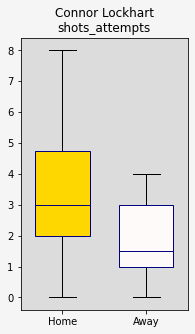

Hayden Fowler
num home games: 17
num away games: 17
['faceoff_lost', 'penalty_taken']



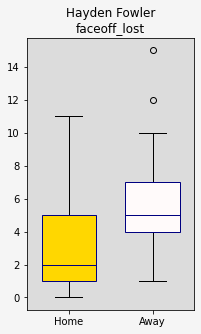

Jamie Drysdale
num home games: 15
num away games: 15
[]

Kurtis Henry
num home games: 19
num away games: 21
['penalty_taken']



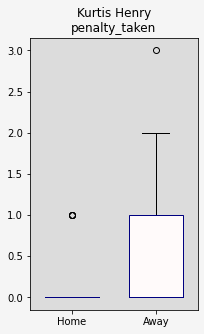

Brendan Sellan
num home games: 19
num away games: 21
[]

Danial Singer
num home games: 10
num away games: 9
['goals', 'zone_entry_played', 'inc_play_indirect']



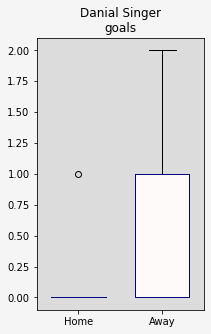

Austen Swankler
num home games: 18
num away games: 19
['play_indirect', 'play_direct', 'play_total', 'play_attempts']



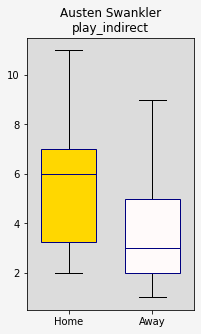

Jacob Golden
num home games: 17
num away games: 17
['inc_play_indirect']



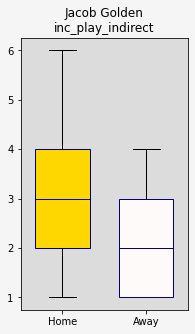

Emmett Sproule
num home games: 19
num away games: 21
[]

Jack Duff
num home games: 19
num away games: 21
[]

Chad Yetman
num home games: 19
num away games: 20
['faceoff_win', 'faceoff_percent']



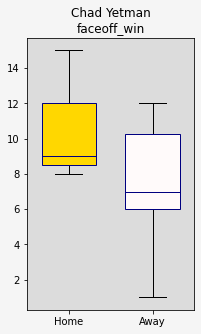

Maxim Golod
num home games: 19
num away games: 21
['faceoff_win', 'faceoff_lost']



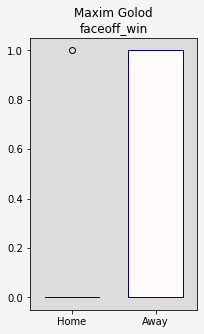

Elias Cohen
num home games: 16
num away games: 19
['shots_blocked']



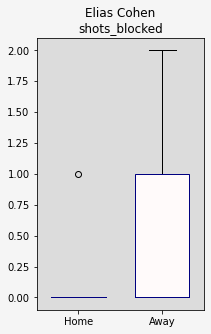

Brendan Kischnick
num home games: 7
num away games: 10
[]

Brendan Hoffmann
num home games: 19
num away games: 21
[]

Luke Beamish
num home games: 6
num away games: 4
[]

Daniel D'Amato
num home games: 19
num away games: 21
['faceoff_lost', 'inc_play_total']



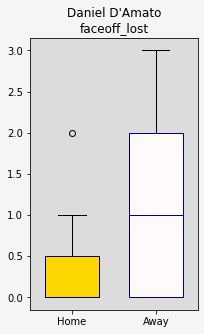

Daniel Murphy
num home games: 13
num away games: 15
['play_direct', 'inc_play_indirect']



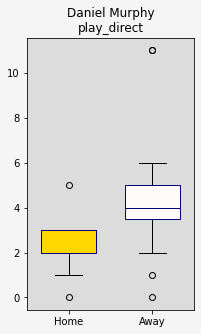

Aidan Campbell
num home games: 8
num away games: 9
[]

Cameron Morton
num home games: 17
num away games: 19
[]

Noah Sedore
num home games: 14
num away games: 14
[]

Matthew MacDougall
num home games: 9
num away games: 7
[]

Christian Kyrou
num home games: 3
num away games: 7
['shots_attempts', 'shots_blocked']



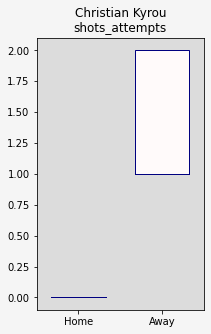

Drew Hunter
num home games: 12
num away games: 16
['shots_on_net']



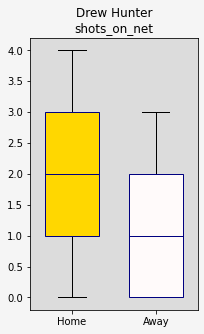

Kyen Sopa
num home games: 9
num away games: 6
['shots_on_net', 'inc_play_total']



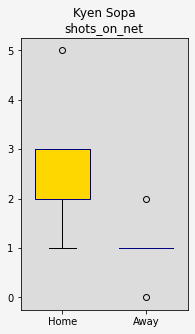

unaffected players:
['Jamie Drysdale',
 'Brendan Sellan',
 'Emmett Sproule',
 'Jack Duff',
 'Brendan Kischnick',
 'Brendan Hoffmann',
 'Luke Beamish',
 'Aidan Campbell',
 'Cameron Morton',
 'Noah Sedore',
 'Matthew MacDougall']


In [8]:
unaffected_players = []
sig_effects = {}
total_player_count = 0
for player, games in players.items():
    df_player = pd.DataFrame.from_dict(games, orient='index')
    if len(df_player) < 8:  # players with less than 5 games have sample size too small to test for significance
        continue
    total_player_count += 1
    
    # do a little more data wrangling
    df_player['play_total'] = df_player['play_direct'] + df_player['play_indirect']
    df_player['inc_play_total'] = df_player['inc_play_direct'] + df_player['inc_play_indirect']
    df_player['play_attempts'] = df_player['play_total'] + df_player['inc_play_total']
    df_player['shots_attempts'] = df_player['shots_blocked'] + df_player['shots_on_net'] + df_player['shots_missed']
    df_player['faceoff_percent'] = df_player['faceoff_win'] / (df_player['faceoff_win'] + df_player['faceoff_lost'])
    
    # split dataframe into home and away stats
    df_home = df_player[df_player['home']==1]  # home stats
    df_away = df_player[df_player['home']==0]  # away stats
    
    # test each stat for significant difference in means between home and away games
    columns = df_home.columns.values.tolist()[1:]  # list of columns
    sig_results = []
    t_results = []
    for c in columns:
        t_result = ttest_ind(df_home[c], df_away[c], equal_var=False)
        if c not in sig_effects:
            sig_effects[c] = 0
        if t_result.pvalue < 0.05:  # significant difference between home and away games found in this stat 'c'
            sig_results.append(c)
            t_results.append(t_result)
            sig_effects[c] += 1
    
    # if a player has no significant differences in stats between home and away games, add to list of 'unaffected players'
    if len(sig_results) == 0:
        unaffected_players.append(player)
    print(player)
    print('num home games: ' + str(len(df_home)))
    print('num away games: ' + str(len(df_away)))
    print(sig_results)
    print()
    draw_boxplot(sig_results, df_home, df_away, player)

print('unaffected players:')
pprint.pprint(unaffected_players)



In [9]:
df_sig_effects = pd.DataFrame.from_dict(sig_effects, orient='index')
df_sig_effects.columns = ['Significant Counts']
print('Number of players in testing: ' + str(total_player_count))
print('Number of metrics tracked: ' + str(len(df_sig_effects)))
print('Total effects found: ' + str(int(df_sig_effects['Significant Counts'].sum())))
print('Maximum possible effects: ' + str(total_player_count * len(df_sig_effects)))
df_sig_effects

Number of players in testing: 25
Number of metrics tracked: 21
Total effects found: 27
Maximum possible effects: 525


,Significant Counts
dump_retained,0
dump_lost,0
faceoff_win,2
faceoff_lost,3
goals,1
shots_attempts,2
shots_on_net,2
shots_missed,1
shots_blocked,2
zone_entry_carried,0


## Review
Highlight some interesting significant differences that we found

##### Hayden Fowler and Penalties Taken
A significant difference in the mean amount of penalties taken between home and away games was found in Fowler's data (t=-2.46, p-val=0.02). While the distribution for 'penalties taken' is skewed to the left (most games have values of zero), it was found the Fowler takes many more penaties in away games than he does in home games. In fact, in Fowler's 17 home games, there are only three games where he takes a single penalty. In Fowler's 17 away games, there are 8 occurences where he takes at least one penalty and 5 occurences of multi-penalty games.

The significant difference in penalties taken begs the question, 'What is causing Fowler to display a lower level of discipline in road games?' It is possible that this player loses discipline due to the demands of travel.   

Fowler's penalties in 17 home games:
2019-09-20    0
2019-10-04    1
2019-10-11    0
2019-10-12    0
2019-10-19    0
2019-10-23    0
2019-10-26    0
2019-11-15    1
2019-12-08    0
2019-12-31    0
2020-01-11    0
2020-01-12    1
2020-02-07    0
2020-02-08    0
2020-02-12    0
2020-03-04    0
2020-03-08    0
Name: penalty_taken, dtype: int64

Fowler's penalties in 17 away games:
2019-09-21    1
2019-09-26    0
2019-10-17    2
2019-10-18    1
2019-11-09    2
2019-11-17    3
2019-11-21    0
2019-11-22    0
2019-12-13    2
2019-12-15    0
2019-12-29    0
2020-01-03    0
2020-01-05    0
2020-01-17    0
2020-01-18    0
2020-01-31    3
2020-03-07    1
Name: penalty_taken, dtype: int64

Ttest_indResult(statistic=-2.4688535993934706, pvalue=0.02272101999330909)


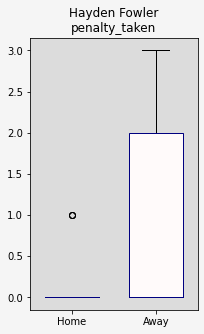

In [10]:
stat = 'penalty_taken'
df_tmp = pd.DataFrame.from_dict(players['Hayden Fowler'], orient='index')
print('Fowler\'s penalties in ' + str(len(df_tmp[df_tmp['home']==1])) + ' home games:')
print(df_tmp[df_tmp['home']==1][stat])
print()
print('Fowler\'s penalties in ' + str(len(df_tmp[df_tmp['home']==0])) + ' away games:')
print(df_tmp[df_tmp['home']==0][stat])
print()
print(ttest_ind(df_tmp[df_tmp['home']==1][stat], df_tmp[df_tmp['home']==0][stat], equal_var=False))
fig = draw_boxplot(['penalty_taken'], df_tmp[df_tmp['home']==1], df_tmp[df_tmp['home']==0], 'Hayden Fowler')
fig.savefig(str('output/' + stat + '_' + 'Fowler'), dpi=fig.dpi)

##### Austen Swankler and Complete Passes
Among Austen Swankler's performance, a significant difference in the average number of complete passes between home and away games was found (t=3.14, p-val=0.003). In our data, tracking the number of complete passes serves as a proxy for measuring puck possession. It can be generalized that increasing puck possession increases probability team success. Swankler has decreased puck possession in away games and, therefore, decreases his team's liklihood of winning away games.

When comparing Swankler's home and away possession metrics (number of complete passes), we notice a significant decrease in possession when Swankler plays away games.

Swankler's total complete passes in 18 home games:
Average complete passes: 19.88888888888889

Swankler's total complete passes in 19 away games:
Average complete passes: 14.473684210526315

Ttest_indResult(statistic=3.1428826722615018, pvalue=0.0034331200638436222)


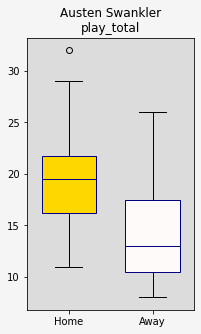

In [11]:
stat = 'play_total'
df_tmp = pd.DataFrame.from_dict(players['Austen Swankler'], orient='index')
df_tmp['play_total'] = df_tmp['play_direct'] + df_tmp['play_indirect']
print('Swankler\'s total complete passes in ' + str(len(df_tmp[df_tmp['home']==1])) + ' home games:')
print('Average complete passes: ' + str(float(df_tmp[df_tmp['home']==1][stat].mean())))
print()
print('Swankler\'s total complete passes in ' + str(len(df_tmp[df_tmp['home']==0])) + ' away games:')
print('Average complete passes: ' + str(float(df_tmp[df_tmp['home']==0][stat].mean())))
print()
print(ttest_ind(df_tmp[df_tmp['home']==1][stat], df_tmp[df_tmp['home']==0][stat], equal_var=False))
fig = draw_boxplot(['play_total'], df_tmp[df_tmp['home']==1], df_tmp[df_tmp['home']==0], 'Austen Swankler')
fig.savefig(str('output/' + stat + '_' + 'Swankler'), dpi=fig.dpi)

##### Chad Yetman and Faceoff Percentage
It was found that Chad Yetman won 10% less faceoffs in road games than in home games. This difference was found to be significant (t=2.73 p-val=0.009). Faceoff percentage can be another measure puck possession--usually winning a faceoff gives your team possession of the puck to start a play. Yetman's decreased faceoff percentage in road games hurts his team's possession metrics and, additionally, can hurt his teams ability to score goals (you cannot score goals if you do not have possession of the puck).

Yetman's faceoff percentage in 19 home games:
0.5242296342302364
faceoffs taken: 379

Yetman's faceoff percentage in 20 away games:
0.42353166542256593
faceoffs taken: 345

Ttest_indResult(statistic=2.727566993808008, pvalue=0.009754909856309411)


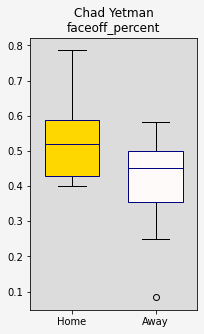

In [12]:
stat = 'faceoff_percent'
df_tmp = pd.DataFrame.from_dict(players['Chad Yetman'], orient='index')
df_tmp['play_total'] = df_tmp['play_direct'] + df_tmp['play_indirect']
df_tmp['faceoff_percent'] = df_tmp['faceoff_win'] / (df_tmp['faceoff_win'] + df_tmp['faceoff_lost'])
print('Yetman\'s faceoff percentage in ' + str(len(df_tmp[df_tmp['home']==1])) + ' home games:')
print(df_tmp[df_tmp['home']==1][stat].mean())
print('faceoffs taken: ' + str(int(df_tmp[df_tmp['home']==1]['faceoff_win'].sum()) + df_tmp[df_tmp['home']==1]['faceoff_lost'].sum()))
print()
print('Yetman\'s faceoff percentage in ' + str(len(df_tmp[df_tmp['home']==0])) + ' away games:')
print(df_tmp[df_tmp['home']==0][stat].mean())
print('faceoffs taken: ' + str(int(df_tmp[df_tmp['home']==0]['faceoff_win'].sum()) + df_tmp[df_tmp['home']==0]['faceoff_lost'].sum()))
print()
print(ttest_ind(df_tmp[df_tmp['home']==1][stat], df_tmp[df_tmp['home']==0][stat], equal_var=False))
fig = draw_boxplot(['faceoff_percent'], df_tmp[df_tmp['home']==1], df_tmp[df_tmp['home']==0], 'Chad Yetman')
fig.savefig(str('output/' + stat + '_' + 'Yetman'), dpi=fig.dpi)

##### Unaffected Players
Below is a printout of players without significant differences in stats between home and away games. After running 2-sample t-tests to compare each stat for differences in home and away performance, no significant differences were uncovered. These players play at the same level regardless of where a game is played and how much travel is required to get to a game.

In [13]:
unaffected_data = {}

# get player stat totals 
for player_name in unaffected_players:
    unaffected_data[player_name] = {}
    all_players_games = players[player_name]
    for game, stat_list in all_players_games.items():
        if len(unaffected_data[player_name]) == 0:
            unaffected_data[player_name] = stat_list.copy()
            continue
        for stat, value in stat_list.items():
            unaffected_data[player_name][stat] += value

df_unaffected = pd.DataFrame.from_dict(unaffected_data, orient='index')
df_unaffected['play_total'] = df_unaffected['play_direct'] + df_unaffected['play_indirect']
df_unaffected.sort_values(['play_total', 'goals'], inplace=True, ascending=False)
df_unaffected[['shots_on_net', 'goals', 'play_total']]
# unaffected_data['Jamie Drysdale']

,shots_on_net,goals,play_total
Jamie Drysdale,75,6,1132
Jack Duff,56,2,769
Emmett Sproule,60,8,552
Brendan Sellan,80,9,530
Cameron Morton,30,2,397
Brendan Hoffmann,74,8,359
Luke Beamish,11,0,261
Noah Sedore,20,1,199
Brendan Kischnick,12,0,180
Aidan Campbell,0,0,177
